In [1]:
import torch
import torch.nn as nn
from pathlib import Path
import torchvision.transforms as transforms
import torch.optim as optim
import numpy as np
from math import *
import torch.distributions as tdist
from random import gauss,seed

In [20]:
import sys 
sys.path.insert(0,'/home/mohit.kumargupta/deep_boltzmann')
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from IPython.display import SVG

In [21]:
from deep_boltzmann.models import ParticleDimer
md = ParticleDimer()

/home/mohit.kumargupta/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mohit.kumargupta/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/mohit.kumargupta/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/mohit.kumargupta/.local/lib/python3.6/site-packages/ten

In [4]:
trajdict = np.load('output.npz')
import ast
#params = ast.literal_eval(str(trajdict['params']))
traj_closed_train = trajdict['traj_closed_train_hungarian']
traj_open_train = trajdict['traj_open_train_hungarian']
traj_closed_test = trajdict['traj_closed_test_hungarian']
traj_open_test = trajdict['traj_open_test_hungarian']
x = np.vstack([traj_closed_train, traj_open_train])
xval = np.vstack([traj_closed_test, traj_open_test])

In [5]:
def thresholdFunction(output, threshold):
    total = 0 
    for eachOutput in output:
        if(eachOutput>threshold):
            total += 1
    return total

In [6]:
def samplingOfMixture(Model,loader):
    sampled = None
    t = None
    real = None
    for i, data in enumerate(loader, 0):
        data= data.type(torch.FloatTensor)
        if(t is not None):
            t = torch.cat((t,data[:,:4]),0)
        else:
            t = data[:,:4] 
        if(sampled is not None):
            sampled = torch.cat((sampled, Model.sample(data[:,:4]) ),0)
        else:
            sampled = Model.sample(data[:,:4])
        if(real is not None):
            real = torch.cat( (real, data), 0)
        else:
            real = data
        break
    FullConfiguration = torch.cat((t,sampled), 1)
    return FullConfiguration, real

In [7]:
class RNADE2(nn.Module):
    def __init__(self,dimer_atoms,solvent_atoms):
        super(RNADE2, self).__init__()
        self.dimer_atoms = dimer_atoms
        self.solvent_atoms = solvent_atoms
        self.D = self.dimer_atoms + self.solvent_atoms
        self.H = 16
        self.K = 3
        self.params = nn.ParameterDict({
            "V" : nn.Parameter(torch.randn(self.D, self.H)),
            "b" : nn.Parameter(torch.zeros(self.D)),
            "V2" : nn.Parameter(torch.randn(self.D, self.H)),
            "b2" : nn.Parameter(torch.zeros(self.D)),
            "Vmean" : nn.Parameter(torch.randn(self.D,self.H, self.K)),
            "Valpha" : nn.Parameter(torch.randn(self.D,self.H, self.K)),
            "Vstd" : nn.Parameter(torch.randn(self.D,self.H, self.K)),
            "bmean" : nn.Parameter(torch.zeros(self.D,self.K)),
            "balpha" : nn.Parameter(torch.zeros(self.D,self.K)),
            "bstd" : nn.Parameter(torch.zeros(self.D,self.K)),
            "W" : nn.Parameter(torch.randn(self.H, self.D)),
            "c" : nn.Parameter(torch.zeros(1, self.H)),
        })
        nn.init.xavier_normal_(self.params["V"])
        nn.init.xavier_normal_(self.params["V2"])
        nn.init.xavier_normal_(self.params["W"])
        nn.init.xavier_normal_(self.params["Vmean"])
        nn.init.xavier_normal_(self.params["Valpha"])
        nn.init.xavier_normal_(self.params["Vstd"])
        
    def forward(self, x):
        ai = self.params["c"].expand(x.size(0), -1)   #B x H
        a= None
        m = None
        s = None
        for d in range(self.D):
            if(d<4):
                ai = x[:, d:d+1].mm(self.params["W"][:,d:d+1].t()) + ai
                continue
            h_i = torch.relu(ai) #B x H
            std = torch.sigmoid( ( h_i.mm(self.params["Vstd"][d,:,] ) + self.params["bstd"][d:d+1,:].expand(x.size(0), -1) ) )*2  + pow(10,-1) + 0.5#  BxH *  HxK = BxK  
            mean = ( h_i.mm(self.params["Vmean"][d,:,] ) + self.params["bmean"][d:d+1,:].expand(x.size(0), -1) ) #B xH  * HxK  = B x K + BxK
            alpha = torch.softmax( (h_i.mm(self.params["Valpha"][d,:,] ) +self.params["balpha"][d:d+1,:].expand(x.size(0), -1) ), dim = 1 )
            print(alpha.size())
            if(a is not None):
                a = torch.cat((a, alpha.unsqueeze(dim = 0)),0)
                m = torch.cat((m, mean.unsqueeze(dim = 0)) , 0)
                s = torch.cat((s, std.unsqueeze(dim = 0)) , 0)
            else:
                a = alpha.unsqueeze(dim=0)
                m = mean.unsqueeze(dim=0)
                s = std.unsqueeze(dim=0)
            ai = x[:, d:d+1].mm(self.params["W"][:, d:d+1].t() ) + ai #Bx1 * 1xH =  BxH
        
        m = m.permute(1,0,2 )
        a = a.permute(1,0,2)
        s = s.permute(1,0,2)
        return [m,s,a]
    
    def mixtureSample(self, pm):
        alpha = pm[0]
        mean = pm[1]
        ans = []
        std = pm[2]
        for i in range(alpha.size()[0]):
            while(1):
                r = np.random.rand()*6  -3
                prob = 0.0
                for j in range(alpha.size()[1] ):
                    prob = prob + ( alpha[i,j] * torch.exp(-0.5* ((r-mean[i,j])/std[i,j])**2) / ( std[i,j]  * sqrt(2*3.14)) ).detach().numpy()
                if(prob>= np.random.rand()):
                    ans.append(r)
                    break
        return torch.from_numpy( np.array(ans)).type(torch.DoubleTensor);
            
    def sample(self,x):
        ai = self.params["c"].expand(x.size(0), -1)   #B x H
        a= None
        m = None
        s = None
        boj = []
        for d in range(self.D):
            if(d<4):
                #print(x[:,d:d+1].size(), self.params["W"][:,d:d+1].t().size(),x[:,d:d+1].dtype)
                ai = x[:, d:d+1].mm(self.params["W"][:,d:d+1].t()) + ai
                continue
            h_i = torch.relu(ai) #B x H
            std = torch.sigmoid( ( h_i.mm(self.params["Vstd"][d,:,] ) + self.params["bstd"][d:d+1,:].expand(x.size(0), -1) ) )*2  + pow(10,-1) + 0.5#  BxH *  HxK = BxK  
            mean = ( h_i.mm(self.params["Vmean"][d,:,] ) + self.params["bmean"][d:d+1,:].expand(x.size(0), -1) ) #B xH  * HxK  = B x K + BxK
            alpha = torch.softmax( (h_i.mm(self.params["Valpha"][d,:,] ) +self.params["balpha"][d:d+1,:].expand(x.size(0), -1) ), dim = 1 )
            ind = torch.argmax(alpha,dim=1)
            samples = mean[:,0:1]
          
            '''
            samples = self.mixtureSample([alpha,mean,std]).unsqueeze(dim=0).t()
            samples = samples.type(torch.FloatTensor)
            '''
            boj.append(samples)
            ai = samples.mm(self.params["W"][:, d:d+1].t() ) + ai
            
        boj = torch.cat(boj,1)
        return boj

In [11]:
#RNADE
class RNADE(nn.Module):
    def __init__(self,dimer_atoms,solvent_atoms):
        super(RNADE, self).__init__()
        self.dimer_atoms = dimer_atoms
        self.solvent_atoms = solvent_atoms
        self.total_dims = self.dimer_atoms + self.solvent_atoms
        self.D = self.total_dims
        self.H = 64
        self.params = nn.ParameterDict({
            "V" : nn.Parameter(torch.randn(self.D, self.H)),
            "b" : nn.Parameter(torch.zeros(self.D)),
            "V2" : nn.Parameter(torch.randn(self.D, self.H)),
            "b2" : nn.Parameter(torch.zeros(self.D)),
            "W" : nn.Parameter(torch.randn(self.H, self.D)),
            "c" : nn.Parameter(torch.zeros(1, self.H)),
        })
        nn.init.xavier_normal_(self.params["V"])
        nn.init.xavier_normal_(self.params["V2"])
        nn.init.xavier_normal_(self.params["W"])
        
    def forward(self, x):
        ai = self.params["c"].expand(x.size(0), -1)   #B x H
        a1=[]
        m1 = []
        for d in range(self.D):
            h_i = torch.relu(ai) #B x H
            alpha1 = torch.sigmoid( h_i.mm(self.params["V"][d:d+1,:].t() ) + self.params["b"][d:d+1] )*2  + pow(10,-1) + 0.5#  BxH *  Hx1  
            mean1 = h_i.mm(self.params["V2"][d:d+1,:].t() ) + self.params["b2"][d:d+1]
            a1.append(alpha1)
            m1.append(mean1)
            ai = x[:, d:d+1].mm(self.params["W"][:, d:d+1].t() ) + ai #Bx1 * 1xH =  BxH
        
        a1 = torch.cat(a1,1)
        m1 = torch.cat(m1,1)
        final_prob = torch.stack([m1,a1])       
     
        return final_prob

    def sample(self, x):
        ai = self.params["c"].expand(x.size(0), -1)
        means = []
        alphas = []
        boj = []
        sample = x
        for d in range(self.D):
            h_i = torch.relu(ai)
            if(d<4):
                ai = sample[:, d:d+1].mm(self.params["W"][:,d:d+1].t()) + ai
                continue
            alpha = torch.sigmoid( h_i.mm(self.params["V"][d:d+1,:].t() ) + self.params["b"][d:d+1] )*2  + pow(10,-1) + 0.5#  BxH *  Hx1  
            mean = h_i.mm(self.params["V2"][d:d+1,:].t() ) + self.params["b2"][d:d+1]
            means.append(mean)
            alphas.append(alpha)
            x1 = mean
            boj.append(x1)
            ai = x1.mm(self.params["W"][:, d:d+1].t() ) + ai
        boj = torch.cat(boj,1)
        print(boj)
        return boj

In [26]:
PATH = "RNADECombine2"
device = "cpu"

In [27]:
model = RNADE(4,72).to(device)
model.load_state_dict(torch.load(PATH))
model.eval()

RNADE(
  (params): ParameterDict(
      (V): Parameter containing: [torch.FloatTensor of size 76x64]
      (V2): Parameter containing: [torch.FloatTensor of size 76x64]
      (W): Parameter containing: [torch.FloatTensor of size 64x76]
      (b): Parameter containing: [torch.FloatTensor of size 76]
      (b2): Parameter containing: [torch.FloatTensor of size 76]
      (c): Parameter containing: [torch.FloatTensor of size 1x64]
  )
)

In [28]:
def generateDenser(dist):
    nSamples =100
    pi = 3.14
    x1 =  np.random.rand(nSamples) *0.2 -dist/2
    y1 = np.random.rand(nSamples) * 0.2 -0.1
    angle = np.random.rand(nSamples) * np.pi/6 - np.pi/12
    x2= x1 + dist *np.cos(angle)
    y2 = y1 + dist*np.sin(angle)
    return np.transpose( np.array([x1,y1,x2,y2]) )

In [35]:
data = generateDenser(2.0)

In [36]:
batch_size = 200

In [37]:
train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=False)

In [38]:
[PredictedConfig, RealConfig] = samplingOfMixture(model,train_loader)

tensor([[-3.0212, -2.9132, -2.9084,  ...,  1.6394,  2.9890,  2.8589],
        [-2.9738, -2.9668, -2.9517,  ...,  1.5559,  2.9876,  2.8226],
        [-2.9878, -2.9329, -2.9634,  ...,  1.5518,  2.9727,  2.8308],
        ...,
        [-3.0167, -2.9138, -2.9286,  ...,  1.5626,  2.9785,  2.8291],
        [-2.9703, -2.9591, -2.9919,  ...,  1.5604,  2.9779,  2.8443],
        [-2.9953, -2.9322, -2.8834,  ...,  1.8007,  2.9995,  2.9563]],
       grad_fn=<CatBackward>)


In [39]:
PredictedConfigEnergy = md.energy(np.array(PredictedConfig.detach()))

In [40]:
print(PredictedConfigEnergy)

[ 105.579216    167.81530762  161.68278503  325.61294556  569.4864502
   88.18785095  791.27313232  115.21520233  131.02236938  270.94589233
  972.13366699 1386.28186035   89.88457489  119.55769348  475.25689697
  107.37480927  145.48027039  549.09680176  119.67451477  110.71121979
  589.16845703  278.39855957  117.49777985  106.47904205   97.98345947
  107.29229736  355.81219482  119.77720642   97.8862381   135.37207031
  127.7903595   824.27697754  212.88253784  119.72207642  110.15677643
  223.46299744  142.07939148   95.56497955   94.12478638  321.86602783
  142.73780823  118.9316864   101.27015686   95.2988205   599.67169189
  175.25646973  158.56977844  466.64193726  134.43295288  220.94299316
  100.63288116  589.31170654  142.08114624  157.77360535  726.83050537
 1017.53485107   93.86168671  245.93003845   82.94322205  293.04702759
  342.91409302  189.97029114  477.00811768 1152.40466309  302.55474854
   84.06032562   90.94303131  214.9733429   419.89831543  291.40945435
  105.2

In [23]:
bins = [30,40,50,60,70,80,90,100]

(array([0., 0., 0., 0., 0., 0., 0.]),
 array([ 30,  40,  50,  60,  70,  80,  90, 100]),
 <a list of 7 Patch objects>)

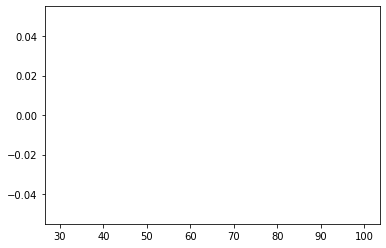

In [24]:
plt.hist(np.array(PredictedConfigEnergy),bins = bins)

<a list of 1 Patch objects>

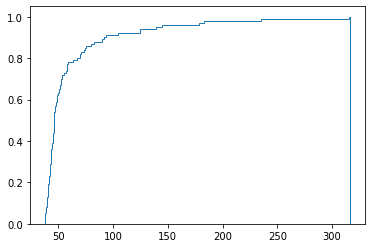

In [19]:
plt.hist(np.array(PredictedConfigEnergy), 400, density = True, cumulative = True, histtype='step' )[-1]

tensor([[-2.9676, -2.9656, -2.9646,  ...,  1.7038,  2.9354,  2.9122],
        [-2.9533, -2.8513, -2.9539,  ...,  1.7373,  2.9832,  2.9082],
        [-2.7142, -2.9454, -3.0423,  ...,  1.8540,  2.9869,  3.0307],
        ...,
        [-2.8613, -2.8450, -2.9717,  ...,  1.6680,  2.9951,  2.8442],
        [-2.8469, -2.9546, -3.0214,  ...,  1.8418,  2.9922,  2.9949],
        [-2.7217, -2.9328, -3.0407,  ...,  1.8323,  2.9902,  3.0079]],
       grad_fn=<CatBackward>)
0.95 0
tensor([[-2.9740, -2.8593, -2.9150,  ...,  1.6717,  2.9647,  2.8515],
        [-3.0092, -2.9058, -2.9551,  ...,  1.7008,  2.9451,  2.9094],
        [-2.7902, -2.9831, -3.0296,  ...,  1.8419,  2.9666,  3.0013],
        ...,
        [-2.9233, -2.9681, -2.9993,  ...,  1.6939,  2.9353,  2.9010],
        [-2.9453, -2.8638, -2.9515,  ...,  1.6683,  2.9784,  2.8444],
        [-2.9712, -2.9105, -2.9320,  ...,  1.6647,  2.9623,  2.8547]],
       grad_fn=<CatBackward>)
1.05 0
tensor([[-2.8708, -2.8768, -2.9911,  ...,  1.5271,  2.9986

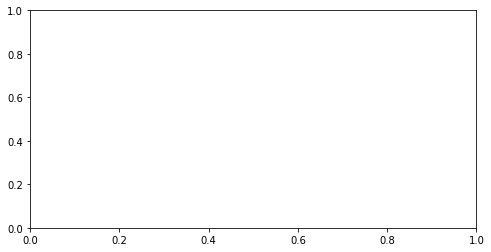

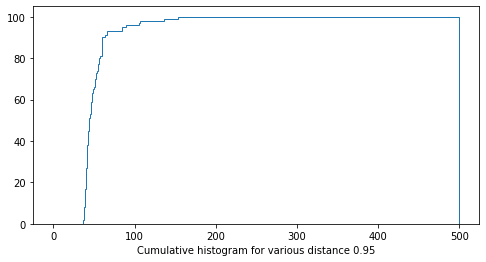

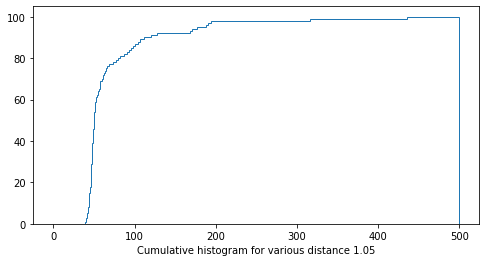

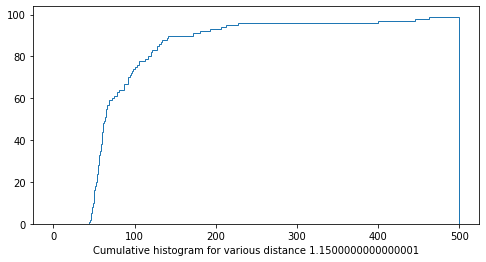

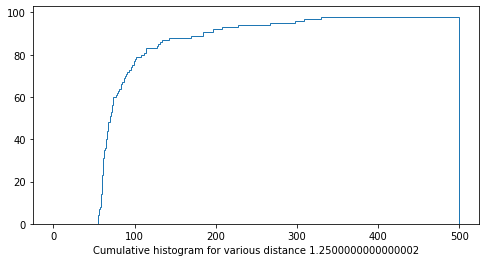

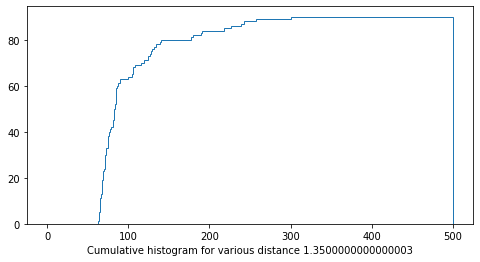

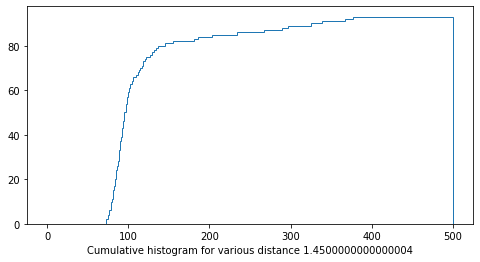

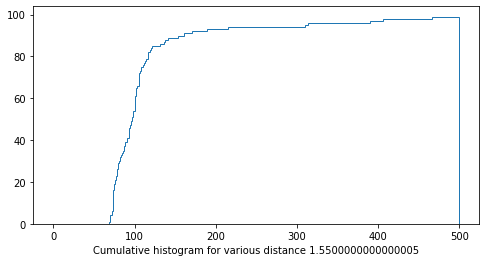

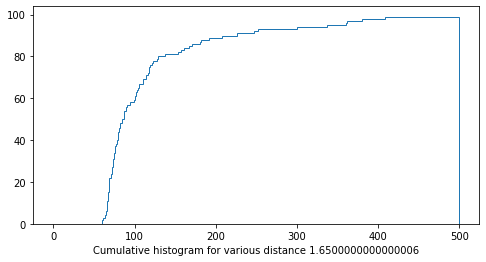

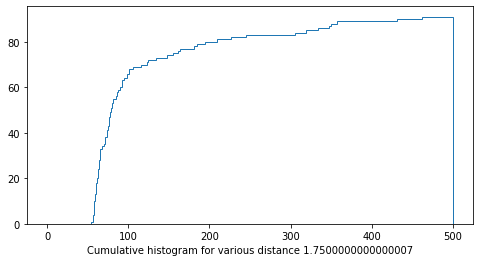

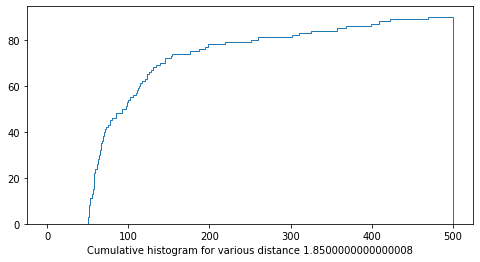

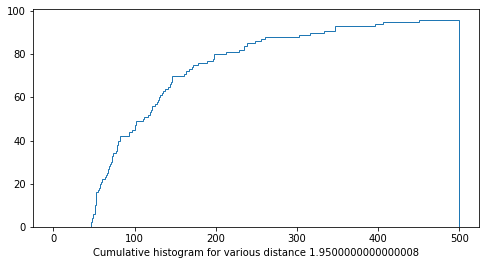

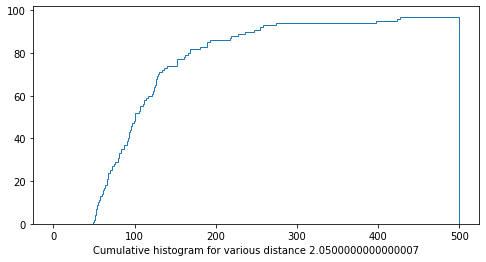

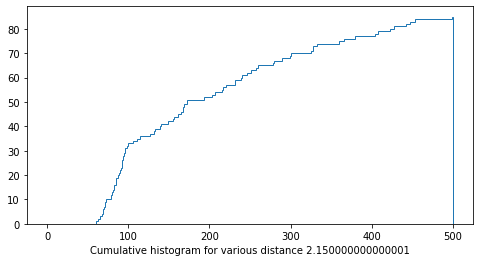

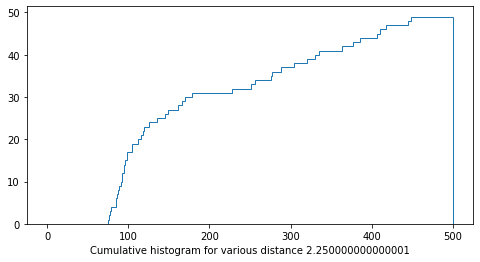

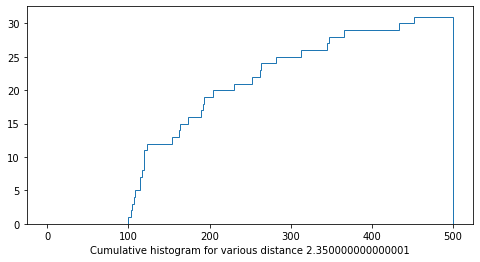

In [20]:
i= 0.95
fig, ax = plt.subplots(figsize=(8, 4))
while(i<= 2.4):
    data = generateDenser(i)
    train_loader = torch.utils.data.DataLoader(data, batch_size=1000, shuffle=False)
    fig, ax = plt.subplots(figsize=(8, 4))
    [PredictedConfig, RealConfig] = samplingOfMixture(model,train_loader)
    PredictedConfigEnergy = md.energy(np.array(PredictedConfig.detach()))
    print(i, thresholdFunction(PredictedConfigEnergy,500))
    ax.hist(np.array(PredictedConfigEnergy), 480, cumulative = True, range= (0,500),  histtype='step')
    ax.plot()
    ax.set_xlabel("Cumulative histogram for various distance " + str(i))
    plt.savefig('CHistOfDist'+  '.pdf')
    i+=0.1000000000000000000

In [62]:
md.energy(traj_open_train[10000::90]).mean()

54.78521964645386

(array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
      

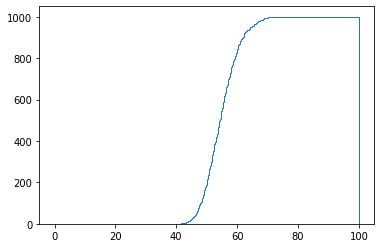

In [166]:
plt.hist(md.energy(traj_open_train[10000::90]),  480, cumulative = True, range= (0,100),  histtype='step')

In [60]:
arr = []

In [61]:
for i in range(90):
    j = np.random.rand() *0.1+ 0.95
    data = generateDenser(j)
    arr = [*arr , *data]

In [62]:
print(len(arr))

9000


tensor([[-3.0231, -2.9151, -2.9504,  ...,  1.5982,  2.9621,  2.8606],
        [-3.0241, -2.9681, -3.0045,  ...,  1.5459,  2.9637,  2.8453],
        [-3.0294, -2.8790, -2.9306,  ...,  1.6564,  2.9690,  2.8922],
        ...,
        [-3.0421, -3.0263, -2.9268,  ...,  1.7963,  2.9669,  2.9564],
        [-3.0187, -2.9079, -2.9301,  ...,  1.6445,  2.9771,  2.8717],
        [-3.0222, -2.9361, -2.9380,  ...,  1.6918,  2.9849,  2.8886]],
       grad_fn=<CatBackward>)
(9000,)


Text(0, 0.5, 'Number of Configurations')

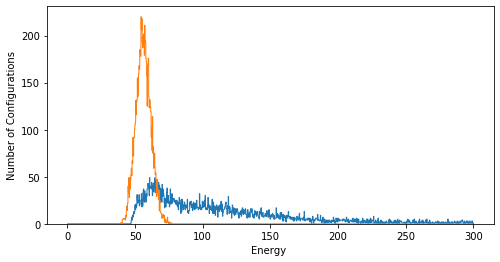

In [68]:
train_loader = torch.utils.data.DataLoader(np.array(arr), batch_size=9000, shuffle=False)
fig, ax = plt.subplots(figsize=(8, 4))
[PredictedConfig, RealConfig] = samplingOfMixture(model,train_loader)
PredictedConfigEnergy = md.energy(np.array(PredictedConfig.detach()))
#print(i, thresholdFunction(PredictedConfigEnergy,500))
print(PredictedConfigEnergy.shape)
ax.hist(np.array(PredictedConfigEnergy), 1000, cumulative = False, range= (0,300),  histtype='step')
ax.hist(md.energy(traj_closed_train[10000::10]),  1000, cumulative = False, range= (0,300),  histtype='step')
ax.plot()
ax.set_xlabel("Energy " )
ax.set_ylabel("Number of Configurations")

In [18]:
arr = []
for i in range(100):
    j = np.random.rand() *0.1+ 2.0
    data = generateDenser(j)
    arr = [*arr , *data]

tensor([[-3.0059, -2.9489, -2.9829,  ...,  1.5532,  2.9818,  2.8144],
        [-2.9858, -2.9660, -2.9858,  ...,  1.5441,  2.9566,  2.8204],
        [-3.0450, -2.9702, -3.0421,  ...,  1.5281,  2.9781,  2.8031],
        ...,
        [-3.0440, -2.9565, -2.9946,  ...,  1.5517,  2.9749,  2.8411],
        [-3.0241, -2.8962, -2.9102,  ...,  1.6590,  2.9846,  2.8790],
        [-3.0842, -2.9602, -2.9630,  ...,  1.7615,  2.9793,  2.9433]],
       grad_fn=<CatBackward>)
99 431


Text(0, 0.5, 'Number of Configurations')

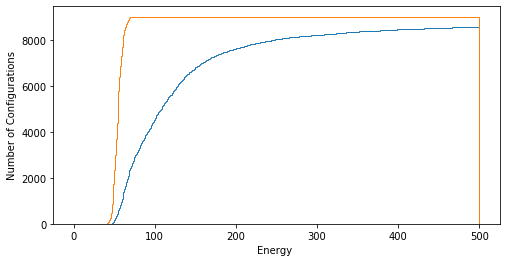

In [19]:
train_loader = torch.utils.data.DataLoader(np.array(arr), batch_size=9000, shuffle=False)
fig, ax = plt.subplots(figsize=(8, 4))
[PredictedConfig, RealConfig] = samplingOfMixture(model,train_loader)
PredictedConfigEnergy = md.energy(np.array(PredictedConfig.detach()))
print(i, thresholdFunction(PredictedConfigEnergy,500))
ax.hist(np.array(PredictedConfigEnergy), 480, cumulative = True, range= (0,500),  histtype='step')
ax.hist(md.energy(traj_open_train[10000::10]),  480, cumulative = True, range= (0,500),  histtype='step')
ax.plot()
ax.set_xlabel("Energy " )
ax.set_ylabel("Number of Configurations")

In [ ]:
model.g

In [59]:
print(len(arr))

1000


(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  3.,  2.,  5., 11., 16., 24., 37., 40., 48., 74., 68.,
        75., 69., 72., 71., 70., 45., 56., 49., 38., 27., 29., 10., 16.,
         8., 14.,  7.,  7.,  4.,  2.,  2.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
         11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
         22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
         33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
         44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
         55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  6

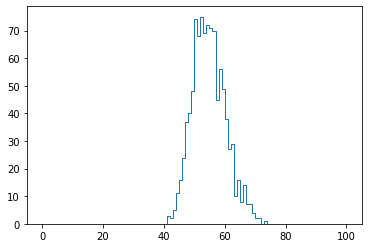

In [29]:
plt.hist(md.energy(traj_open_train[10000::90]),  100, range= (0,100),  histtype='step')